In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
rng = np.random.default_rng(12345)

In [2]:
class Room(object):
    def __init__(self, h, w, c):
        self.update_hwc(h,w,c)
        self.door = []
        self.door_w = 0.9
        self.wall_thickness = 0.1
    def update_hwc(self, h, w, c):
        self.dim = np.array([w,h])
        self.c = c
        
    @classmethod
    def from_vert(cls, vert):
        min_x, max_x = np.min(vert[:,0]),np.max(vert[:,0])
        min_y, max_y = np.min(vert[:,1]),np.max(vert[:,1])
        h = max_y - min_y
        w = max_x - min_x
        c = np.array([max_x+min_x,max_y+min_y])/2
        return cls(h,w,c)
    
    def get_vert(self):
        return self.c + np.array([[self.dim[0], self.dim[1]],[-self.dim[0],self.dim[1]],[-self.dim[0],-self.dim[1]],[self.dim[0],-self.dim[1]]])/2
    
    def get_area(self):
        return self.dim[0]*self.dim[1]
    
    def add_door(self, side):
        s = side
        if side == 0 or side == 2:
            axis = 1
        elif side == 1 or side == 3:
            axis = 0
        
        if side == 0 or side == 3:
            fact = 1
        elif side == 1 or side == 2:
            fact = -1
        door_point = np.zeros([2,2])
        door_point[:,axis] = self.c[axis] + fact*self.dim[axis]/2
        p = rng.beta(1,1)*(self.dim[1-axis]-self.door_w-self.wall_thickness) - (self.dim[1-axis]-self.door_w-self.wall_thickness)/2
        door_point[:,1-axis] = (self.c[1-axis] + p) + np.array([-self.door_w,self.door_w])/2
        self.door.append((door_point,s))
        
        #      0
        #   -------
        #   |     |
        # 1 |     | 3
        #   |     |
        #   -------
        #      2
        
    def get_polygons(self):
        door_add = np.array([[0,-1],[1,0],[0,1],[-1,0]])*self.wall_thickness
        vert_add = np.array([[-1,-1],[1,-1],[1,1],[-1,1]])*self.wall_thickness
        verts = self.get_vert()
        verts_prime = verts+vert_add
        door = self.door[0]
        
        door_points = door[0] if door[1] > 1 else np.flip(door[0],0)
        
        door_points_prime = door_points + door_add[door[1]]
        verts = np.concatenate([verts[door[1]+1:],verts[:door[1]+1]])
        verts_prime = np.concatenate([verts_prime[door[1]+1:],verts_prime[:door[1]+1]])
        
        verts = np.concatenate([door_points[1].reshape((1,-1)),verts,door_points[0].reshape((1,-1))])
        verts_prime = np.concatenate([door_points_prime[1].reshape((1,-1)),verts_prime,door_points_prime[0].reshape((1,-1))])
        verts_prime = np.flip(verts_prime,0)
        
        return np.concatenate([verts, verts_prime])
        
        
        
                

In [3]:
room_h = 15
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
r = Room.from_vert(main_room)

In [5]:
def split_room(room, axis, corridor_w):
    min_, max_ = np.min(room[:,axis]),np.max(room[:,axis])
    split = rng.random()*(max_-min_)+min_
    room1 = room.copy()
    result = []
    room1[room1[:,axis]==min_,axis] = split+corridor_w/2
    room2 = room.copy()
    room2[room2[:,axis]==max_,axis] = split-corridor_w/2
    return [room1, room2]

def split_room(room, axis, corridor_w):
    min_, max_ = np.min(room.get_vert()[:,axis]),np.max(room.get_vert()[:,axis])
    split = rng.random()*(max_-min_)+min_
    split = rng.beta(1,1)*(max_-min_-corridor_w)+min_+corridor_w/2
    #split = rng.normal(room.c[axis], 1.5)
    room1 = room.get_vert().copy()
    result = []
    room1[room1[:,axis]==min_,axis] = split+corridor_w/2
    room1 = Room.from_vert(room1)
    if axis == 0:
        side1 = 1
        side2 = 3
    else:
        side1 = 2
        side2 = 0
    if room.door:
        possible_sides1 = [d[1] for d in room.door]+[side1]
        possible_sides2 = [d[1] for d in room.door]+[side2]
    else:
        possible_sides1 = [side1]
        possible_sides2 = [side2]
        
    room1.add_door(rng.choice(possible_sides1))   
    
    room2 = room.get_vert().copy()
    room2[room2[:,axis]==max_,axis] = split-corridor_w/2
    room2 = Room.from_vert(room2)
    room2.add_door(rng.choice(possible_sides2))
    return [room1, room2]

In [16]:
room_h = 25
room_w = 15

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
main_room = Room.from_vert(main_room)

axis = 1
corridor_w = 1.5
room_num = 6


rooms = []

rooms.append(main_room)
split = split_room(main_room, axis, corridor_w)
rooms=[r for r in split if r.get_area() > 1 and min(r.dim[0],r.dim[1]) > 1.5]


for i in range(room_num):
    if len(rooms) >= room_num:
        break
    axis = 1 - axis
    corridor_w *= 0.9
    num = len(rooms)
    for i in range(num):
        room = rooms.pop(0)
        split = split_room(room, axis, corridor_w)
        split = [r for r in split if r.get_area() > 2 and min(r.dim[0],r.dim[1]) > 1.5]
        rooms+= split if split else [room]
        if len(rooms) >= room_num:
            break
    r_idx = np.argsort([r.get_area() for r in rooms])#np.arange(len(rooms))
    #rng.shuffle(r_idx)
    rooms = [rooms[i] for i in r_idx]

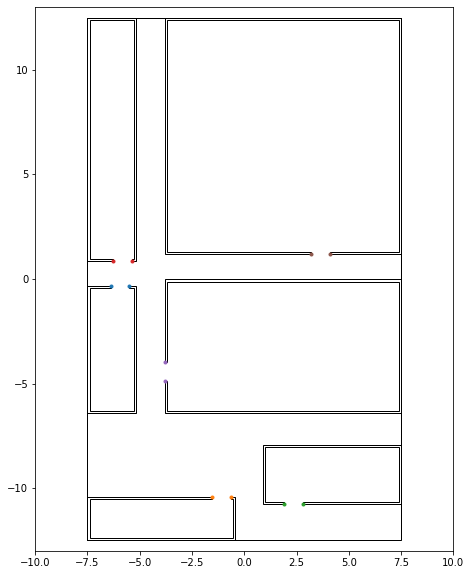

In [17]:
plot_rooms = [main_room]+rooms
fig, ax = plt.subplots(figsize=[10,10])
for r in plot_rooms:
    if r.door:
        polygon = Polygon(np.array(r.get_polygons()), fill=False)
        ax.plot(r.door[0][0][:,0], r.door[0][0][:,1], '.')
    else:
        polygon = Polygon(r.get_vert(), fill=False)
    ax.add_patch(polygon)
    
plt.xlim([-10,10])
plt.ylim([-13,13])
ax.set_aspect('equal', 'box')
plt.show()

In [259]:
polygon.get_xy()

array([[  1.73538984,  -3.27888239],
       [ -7.5       , -12.5       ],
       [  1.73538984, -12.5       ],
       [  1.73538984,   8.8614378 ],
       [ -7.5       ,   8.8614378 ],
       [  1.73538984,  -2.37888239],
       [  2.73538984,  -2.37888239],
       [ -6.5       ,   7.8614378 ],
       [  0.73538984,   7.8614378 ],
       [  0.73538984, -11.5       ],
       [ -6.5       , -11.5       ],
       [  2.73538984,  -3.27888239],
       [  1.73538984,  -3.27888239]])

In [ ]:
min(1,2)

In [44]:
k = 1 if [0] else 2

In [45]:
k

1

In [134]:
p = np.array([[1,2],[2,2]])

In [137]:
np.argwhere(np.equal(p[0],p[1])).flatten()

array([1])

In [4]:
l = np.array([[1,2],[3,4],[5,6]])

In [7]:
rng.choice(l)

array([5, 6])

In [152]:
edge = 0
l[edge+1:]+l[:edge+1]

[2, 3, 4, 1]